# Инициализация нейронной сети

Для того, чтобы нейронная сеть начала обучаться, надо, чтобы через неё проходили градиенты. Поскольку почти всегда используются слои по типу Softmax-а и SigmaLayer-а, где производная при больших по модулю значениях равна нулю, надо следить за тем, чтобы промежуточные значения имели маленький (порядка 1) модуль. Это мы и проверим.

https://www.deeplearning.ai/ai-notes/initialization/

In [1]:
import unittest
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as sps
import seaborn as sns
import pickle
# sns.set(font_scale=1.6)

import simple_nn.mnist as mnist
from simple_nn.layers import DenseLayer, ReluLayer, SoftMaxLayer, LeakyReluLayer, SigmaLayer
from simple_nn.loss_functions import MSE
from simple_nn.optimizers import SGD, LazyOptimizer
from simple_nn.model import Model
from simple_nn.utils import one_hot_digit

Создадим модель с различными слоями, чтобы проверить корректную проводимость значения в каждом.

In [9]:
model = Model()
model.add_layer(DenseLayer(input_size=300, output_size=10))
model.add_layer(LeakyReluLayer())
model.add_layer(DenseLayer(input_size=10, output_size=10))
model.add_layer(ReluLayer())
model.add_layer(DenseLayer(input_size=10, output_size=10))
for _ in range(100):
    model.add_layer(SigmaLayer())
    model.add_layer(DenseLayer(input_size=10, output_size=10))
model.add_layer(SoftMaxLayer())

In [10]:
def analyse_distribution(values):
    values = values.reshape(-1)
    plt.hist(values, bins=100, alpha=0.8, density=True)
    print(f'E={np.mean(values):.2}, D={np.mean((values - np.mean(values)) ** 2):.2}')
    plt.show()

Посмотрим, какие будут промежуточные значения при случайных нормально распределенных данных.

In [11]:
batch_size = 1000
input_v = np.random.normal(size=(batch_size, 300))
desired_v = np.random.normal(size=(batch_size, 10))

output_v = model.fit(input_v, desired_v, MSE(), LazyOptimizer())

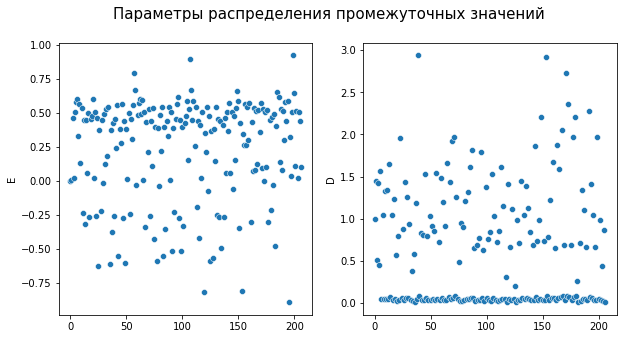

In [12]:
run_data = pd.DataFrame()

for value in model.run_data:
    run_data = run_data.append({
        'E': np.mean(value),
        'D': np.mean(value ** 2) - np.mean(value) ** 2
    }, ignore_index=True)

    
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes = axes.reshape(-1)
fig.suptitle('Параметры распределения промежуточных значений', fontsize=15)

sns.scatterplot(data=run_data, x=run_data.index, y='E', ax=axes[0])
sns.scatterplot(data=run_data, x=run_data.index, y='D', ax=axes[1])
plt.show()

Как видим, всё хорошо, ни дисперсия, ни матожидание значений не превышает по модулю пять.

При этом, если посмотреть на градиенты, видно, как они быстро затухают.

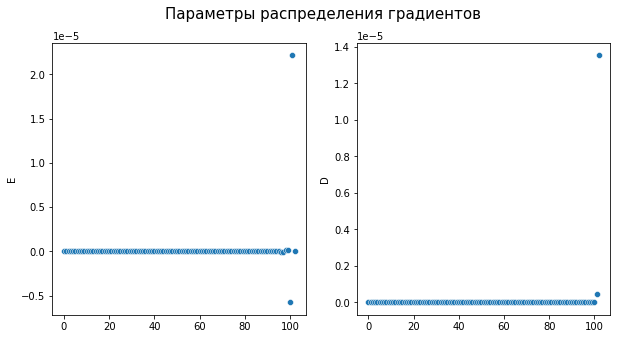

In [13]:
run_data_grad = pd.DataFrame()

for layer in model.layers:
    gradients = layer.get_gradients()
    if len(gradients) == 2:
        gradient = gradients[1]
        run_data_grad = run_data_grad.append({
            'E': np.mean(gradient),
            'D': np.mean(gradient ** 2) - np.mean(gradient) ** 2
        }, ignore_index=True)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes = axes.reshape(-1)
fig.suptitle('Параметры распределения градиентов', fontsize=15)

sns.scatterplot(data=run_data_grad, x=run_data_grad.index, y='E', ax=axes[0])
sns.scatterplot(data=run_data_grad, x=run_data_grad.index, y='D', ax=axes[1])
plt.show()